## Importando as dependências

In [1]:
# Python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Classificadores Scikit-learn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Auxiliadores classificação (k-fold, scaler, pipeline)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set_palette('viridis')

## Importando o dataset

In [3]:
raw_csv_data = pd.read_csv('koi_data.csv') 
df = raw_csv_data.copy() 

In [4]:
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [5]:
print("Distribuição das classes no dataset:")
display(df.groupby('koi_disposition').count().loc[:,['kepoi_name']])

Distribuição das classes no dataset:


,kepoi_name
koi_disposition,
CONFIRMED,2104
FALSE POSITIVE,3098


In [6]:
df.set_index('kepoi_name', inplace=True)

## Seperando o dataset entre X e y (features e classe)

In [7]:
y = df.koi_disposition.values
df.drop('koi_disposition', axis=1, inplace=True)
X = df.values
print('Formato X:', X.shape)
print('Formato y:', y.shape)

Formato X: (5202, 41)
Formato y: (5202,)


## Validação cruzada 5-fold

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits_5_fold = [ (train_index, test_index) for train_index, test_index in cv.split(X, y) ]

## Funções auxiliares

In [9]:
def run_classifier(clf, X_train, X_test, y_train):
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    return y_pred

In [10]:
def find_best_hyperparameter(clf, param_grid, param_name):
    # Execução do algoritmo
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy')
    grid.fit(X, y)
    
    # Mostrando os resultados como pandas dataframe
    results_df = pd.DataFrame(grid.cv_results_).set_index(f'param_{param_name}').loc[:,[ 'mean_test_score', 'std_test_score', 'rank_test_score']]
    results_df.index.names = [param_name]
    display(results_df.sort_values(by='rank_test_score'))
    
    # Encontrando o melhor parâmetro
    best_index = results_df['rank_test_score'].idxmin()
    best_accuracy = results_df.loc[best_index, 'mean_test_score']
    
    # Mostrando os resultados com Matplotlib
    plt.figure(figsize=(10, 5)) 
    results_df.loc[:, 'mean_test_score'].plot(label='Acurácia', color='green')
    plt.scatter(best_index, best_accuracy, color='red', marker='o', label=f'Melhor valor')
    plt.legend()
    plt.show()

In [11]:
def plot_cm(cf_matrix):
    plt.figure(figsize=(4, 3))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

In [12]:
def evaluate_classifier(y_test, y_pred):
    metrics = dict()
    metrics['Precision'] = precision_score(y_test, y_pred, zero_division=0, pos_label='CONFIRMED')
    metrics['Recall/Sensitivity'] = recall_score(y_test, y_pred, zero_division=0, pos_label='CONFIRMED')
    metrics['F1-Score'] = f1_score(y_test, y_pred, zero_division=0, pos_label='CONFIRMED')    
    return metrics

In [13]:
def calculate_mean_metrics(metrics):
    mean_metrics = {clf: {key: np.mean([fold_metric[key] for fold_metric in metrics[clf]]) for key in metrics[clf][0]} for clf in metrics.keys()}
    metrics_df = pd.DataFrame(mean_metrics)
    return metrics_df

# Classificação inicial (Baseline)

In [14]:
accuracies_gnb = []
accuracies_dt = []
accuracies_svc = []
accuracies_knn = []
accuracies_rf = []
accuracies_gtb = []
accuracies_mlp = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    gnb = GaussianNB()
    accuracies_gnb.append(accuracy_score(y_test, run_classifier(gnb, X_train, X_test, y_train)))
    
    dt = DecisionTreeClassifier(random_state=42)
    accuracies_dt.append(accuracy_score(y_test, run_classifier(dt, X_train, X_test, y_train)))
    
    svc = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(random_state=42))] )
    accuracies_svc.append(accuracy_score(y_test, run_classifier(svc, X_train, X_test, y_train)))
    
    knn = Pipeline( steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())] )
    accuracies_knn.append(accuracy_score(y_test, run_classifier(knn, X_train, X_test, y_train)))
    
    rf = RandomForestClassifier(random_state=42)
    accuracies_rf.append(accuracy_score(y_test, run_classifier(rf, X_train, X_test, y_train)))
    
    gtb = GradientBoostingClassifier(random_state=42)
    accuracies_gtb.append(accuracy_score(y_test, run_classifier(gtb, X_train, X_test, y_train)))
    
    mlp = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42))] )
    accuracies_mlp.append(accuracy_score(y_test, run_classifier(mlp, X_train, X_test, y_train)))

c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

In [15]:
print(f'Acurácia Média Gaussian Naive Bayes: {sum(accuracies_gnb) / len(accuracies_gnb):.5f}')
print(f'Acurácia Média Decision Tree: {sum(accuracies_dt) / len(accuracies_dt):.5f}')
print(f'Acurácia Média SVM: {sum(accuracies_svc) / len(accuracies_svc):.5f}')
print(f'Acurácia Média K-NN: {sum(accuracies_knn) / len(accuracies_knn):.5f}')
print(f'Acurácia Média Random Forest: {sum(accuracies_rf) / len(accuracies_rf):.5f}')
print(f'Acurácia Média Gradient Tree Boosting: {sum(accuracies_gtb) / len(accuracies_gtb):.5f}')
print(f'Acurácia Média Multi-layer Perceptron: {sum(accuracies_mlp) / len(accuracies_mlp):.5f}')

Acurácia Média Gaussian Naive Bayes: 0.79815
Acurácia Média Decision Tree: 0.94483
Acurácia Média SVM: 0.93560
Acurácia Média K-NN: 0.89581
Acurácia Média Random Forest: 0.97040
Acurácia Média Gradient Tree Boosting: 0.97001
Acurácia Média Multi-layer Perceptron: 0.95963


# Hyperparameter Tuning

## Decision Tree

,mean_test_score,std_test_score,rank_test_score
max_depth,,,
7,0.947908,0.015105,1
6,0.946563,0.018689,2
8,0.946560,0.020261,3
9,0.945216,0.019732,4
5,0.943486,0.016900,5
10,0.943102,0.023659,6
14,0.941947,0.019458,7
11,0.941756,0.021470,8
22,0.941563,0.020402,9


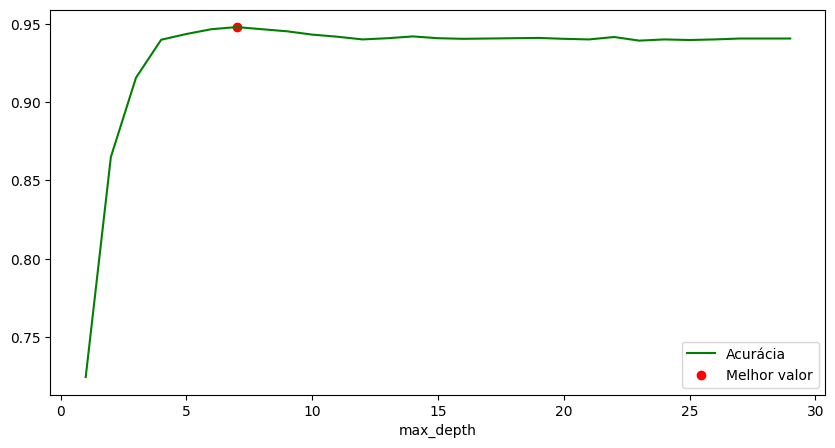

In [16]:
dt = DecisionTreeClassifier()
parameters = { 'random_state': [42], 'max_depth': [ i for i in range(1, 30) ] }
find_best_hyperparameter(dt, parameters, 'max_depth')

### Explicação do experimento
Com árvores de decisão, max_depth determina a altura máxima da árvore.  
Se ela não for especificada, os nodos da árvore são expandidos até que todas as folhas estejam 'puras' (com instâncias apenas de uma classe).  
Expecificar um valor limite para altura da árvore pode aumentar a velocidade do algoritmo, além de previnir 'overfitting'.  
A partir dos experimentos, foi possível perceber que a altura máxima da árvore no nosso caso é 27. logo, (max_depth >= 27) é equivalente a (max_depth = None). 

### Valor escolhido para o hiperparâmetro 
max_depth = 7

## SVM

In [17]:
accuracies_svc_linear = []
accuracies_svc_rbf = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    svc_linear = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(kernel='linear', random_state=42))] )
    accuracies_svc_linear.append(accuracy_score(y_test, run_classifier(svc_linear, X_train, X_test, y_train)))
    
    svc_rbf = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(kernel='rbf', random_state=42))] )
    accuracies_svc_rbf.append(accuracy_score(y_test, run_classifier(svc_rbf, X_train, X_test, y_train)))
print(f'Acurácia Média SVC Linear: {sum(accuracies_svc_linear) / len(accuracies_svc_linear):.5f}')
print(f'Acurácia Média SVC RBF: {sum(accuracies_svc_rbf) / len(accuracies_svc_rbf):.5f}')

Acurácia Média SVC Linear: 0.95117
Acurácia Média SVC RBF: 0.93560


### Explicação do experimento
No SVM, 'kernel' determina a função usada para trasnformar os dados. 
* Kernel linear: Adequado para casos onde os dados são linearmente separáveis.
* Kernel RBF (Radial Basis Function): Adequado para separação de dados que não são linearmente separáveis no seu espaço original.  

O kernel linear apresentou uma precisão maior que o kernel RBF, o que indica que as classes desse dataset são linearmente separáveis.  

### Valor escolhido para o hiperparâmetro
kernel = 'linear'

## KNN

,mean_test_score,std_test_score,rank_test_score
knn__n_neighbors,,,
3,0.888321,0.026989,1
5,0.886397,0.021103,2
9,0.882937,0.025062,3
7,0.882554,0.026433,4
11,0.880439,0.026569,5
13,0.877941,0.025919,6
1,0.877360,0.023920,7
15,0.875826,0.026467,8
17,0.873518,0.026540,9


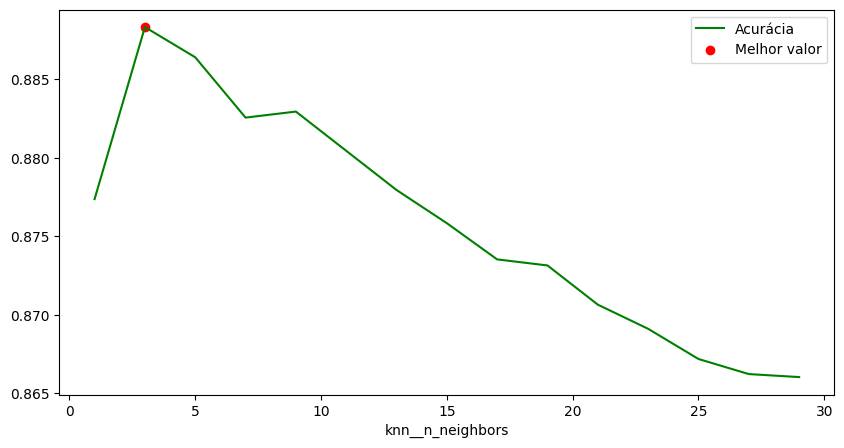

In [18]:
knn = Pipeline( steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())] )
parameters = { 'knn__n_neighbors': [ i for i in range(1, 30, 2) ] }
find_best_hyperparameter(knn, parameters, 'knn__n_neighbors')

### Explicação do experimento
No k-NN, n_neighbors determina o número de vizinhos mais próximos que será usado para classificar novos pontos. *Esse número normalmente é ímpar para não gerar ambiguidade.  
Cuidados com esse valor:  
* Se k for muito pequeno, como k=1, o algoritmo pode se tornar sensível a presença de outliers.  
* Se k for muito grande, o algoritmo pode suavizar as fronteiras entre as classes, por estar levando muitos vizinhos em consideração na hora de classificar novos pontos.  

### Valor escolhido para o hiperparâmetro 
n_neighbors = 3

## Random Forest

,mean_test_score,std_test_score,rank_test_score
n_estimators,,,
150,0.968476,0.010788,1
250,0.968476,0.011142,1
650,0.967899,0.012533,3
600,0.967899,0.012533,3
200,0.967899,0.011503,5
350,0.967899,0.012053,6
450,0.967707,0.012650,7
500,0.967707,0.012280,7
950,0.967707,0.012489,7


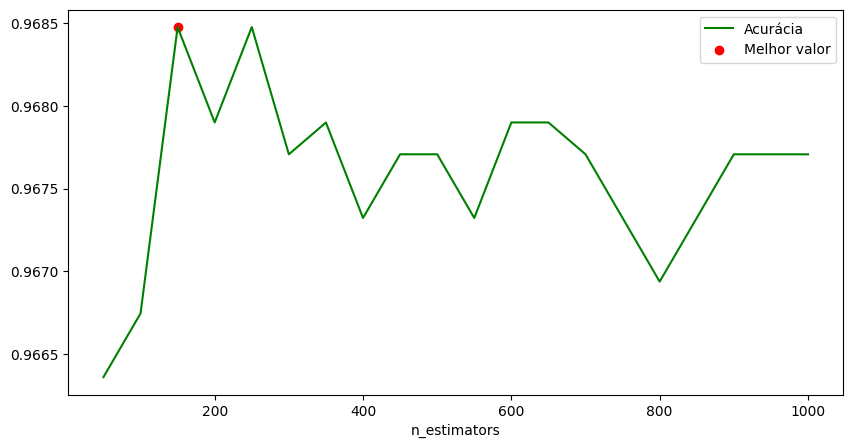

In [19]:
rf = RandomForestClassifier()
parameters = { 'random_state': [42], 'n_estimators': [ i for i in range(50, 1001, 50) ] }
find_best_hyperparameter(rf, parameters, 'n_estimators')

### Explicação do experimento
No Random Forest, n_estimators determina o número de árvores de decisão que serão geradas durante o treinamento. A classificação final é a média das predições dessas árvores.  
O aumento no número de árvores pode aumentar a precisão apesar de aumentar o tempo de treinamento e uso de memória.  
No nosso caso, variar o número de árvores de decisão não gerou um impacto significativo na performance do modelo (intervalo de precisão < 0.3% ).  
Além disso, dois valores empataram na primeira colocação: 150 e 250.  
O desempate foi feito pelo desvio padrão. 

### Valor escolhido para o hiperparâmetro 
n_estimators = 150

##  Gradient Tree Boosting

,mean_test_score,std_test_score,rank_test_score
n_estimators,,,
250,0.967708,0.010959,1
200,0.967516,0.010437,2
150,0.967324,0.011444,3
100,0.964632,0.011690,4
50,0.962517,0.010624,5
20,0.955596,0.008638,6
15,0.951366,0.009043,7
10,0.943486,0.009779,8
5,0.935801,0.019444,9


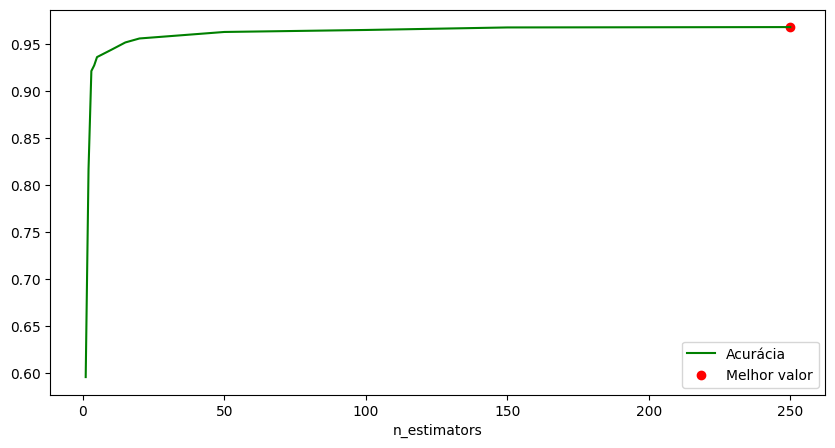

In [34]:
gtb = GradientBoostingClassifier()
parameters = { 'random_state': [42], 'n_estimators': [ 1, 2, 3, 4, 5, 10, 15, 20, 50, 100, 150, 200, 250 ] }
find_best_hyperparameter(gtb, parameters, 'n_estimators')

### Explicação do experimento
No Gradient Tree Boosting, n_estimators determina o número de árvores a serem adicionadas ao modelo. Cada árvore tenta corrigir os erros das árvores anteriores.  
Um número maior de árvores pode aumentar a precisão, mas demandam mais tempo de treinamento.  
No nosso caso é possível observar que a partir de n_estimators = 150, o ganho de precisão é mínimo. Entre 150 e 250, temos um intervalo de precisão < 0.05%.

### Valor escolhido para o hiperparâmetro 
n_estimators = 150

##  Multi-layer Perceptron

### Activation function

In [22]:
accuracies_mlp_identity = []
accuracies_mlp_logistic = []
accuracies_mlp_tanh = []
accuracies_mlp_relu = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp_identity = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='identity'))] )
    accuracies_mlp_identity.append(accuracy_score(y_test, run_classifier(mlp_identity, X_train, X_test, y_train)))
    
    mlp_logistic = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='logistic'))] )
    accuracies_mlp_logistic.append(accuracy_score(y_test, run_classifier(mlp_logistic, X_train, X_test, y_train)))
    
    mlp_tanh = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='tanh'))] )
    accuracies_mlp_tanh.append(accuracy_score(y_test, run_classifier(mlp_tanh, X_train, X_test, y_train)))
    
    mlp_relu = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='relu'))] )
    accuracies_mlp_relu.append(accuracy_score(y_test, run_classifier(mlp_relu, X_train, X_test, y_train)))

c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

In [23]:
print(f'Acurácia Média MLP Identity: {sum(accuracies_mlp_identity) / len(accuracies_mlp_identity):.5f}')
print(f'Acurácia Média MLP Logistic: {sum(accuracies_mlp_logistic) / len(accuracies_mlp_logistic):.5f}')
print(f'Acurácia Média MLP Tanh: {sum(accuracies_mlp_tanh) / len(accuracies_mlp_tanh):.5f}')
print(f'Acurácia Média MLP Relu: {sum(accuracies_mlp_relu) / len(accuracies_mlp_relu):.5f}')

Acurácia Média MLP Identity: 0.95367
Acurácia Média MLP Logistic: 0.95463
Acurácia Média MLP Tanh: 0.95752
Acurácia Média MLP Relu: 0.95963


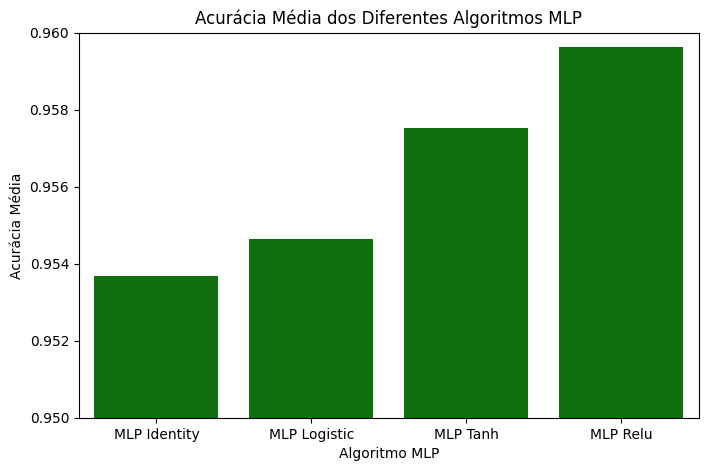

In [24]:
data = {
    'Algoritmo MLP': ['MLP Identity', 'MLP Logistic', 'MLP Tanh', 'MLP Relu'],
    'Acurácia Média': [
        sum(accuracies_mlp_identity) / len(accuracies_mlp_identity),
        sum(accuracies_mlp_logistic) / len(accuracies_mlp_logistic),
        sum(accuracies_mlp_tanh) / len(accuracies_mlp_tanh),
        sum(accuracies_mlp_relu) / len(accuracies_mlp_relu)
    ]
}
accuracies_mlp_df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(x='Algoritmo MLP', y='Acurácia Média', data=accuracies_mlp_df, color='green')
plt.title('Acurácia Média dos Diferentes Algoritmos MLP')
plt.ylim(0.95, 0.96)
plt.show()

### max_iter

In [25]:
accuracies_mlp_identity = []
accuracies_mlp_logistic = []
accuracies_mlp_tanh = []
accuracies_mlp_relu = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp_identity = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='identity', max_iter=10000))] )
    accuracies_mlp_identity.append(accuracy_score(y_test, run_classifier(mlp_identity, X_train, X_test, y_train)))
    
    mlp_logistic = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='logistic', max_iter=10000))] )
    accuracies_mlp_logistic.append(accuracy_score(y_test, run_classifier(mlp_logistic, X_train, X_test, y_train)))
    
    mlp_tanh = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='tanh', max_iter=10000))] )
    accuracies_mlp_tanh.append(accuracy_score(y_test, run_classifier(mlp_tanh, X_train, X_test, y_train)))
    
    mlp_relu = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='relu', max_iter=10000))] )
    accuracies_mlp_relu.append(accuracy_score(y_test, run_classifier(mlp_relu, X_train, X_test, y_train)))
    break

In [26]:
print(f'Acurácia Média MLP Identity: {sum(accuracies_mlp_identity) / len(accuracies_mlp_identity):.5f}')
print(f'Acurácia Média MLP Logistic: {sum(accuracies_mlp_logistic) / len(accuracies_mlp_logistic):.5f}')
print(f'Acurácia Média MLP Tanh: {sum(accuracies_mlp_tanh) / len(accuracies_mlp_tanh):.5f}')
print(f'Acurácia Média MLP Relu: {sum(accuracies_mlp_relu) / len(accuracies_mlp_relu):.5f}')

Acurácia Média MLP Identity: 0.95293
Acurácia Média MLP Logistic: 0.95869
Acurácia Média MLP Tanh: 0.95581
Acurácia Média MLP Relu: 0.96446


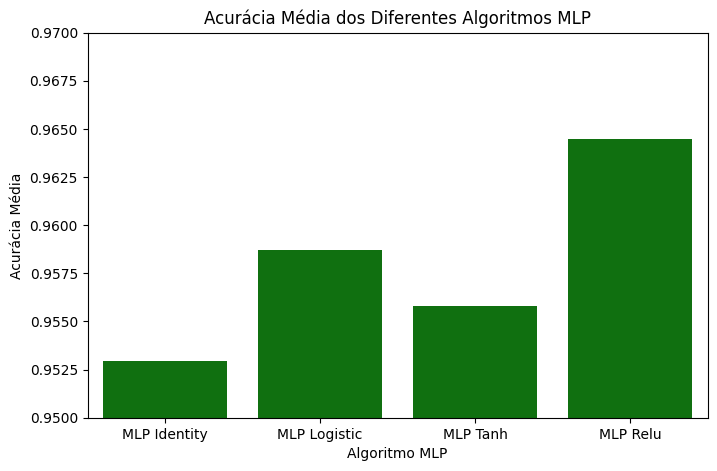

In [27]:
data = {
    'Algoritmo MLP': ['MLP Identity', 'MLP Logistic', 'MLP Tanh', 'MLP Relu'],
    'Acurácia Média': [
        sum(accuracies_mlp_identity) / len(accuracies_mlp_identity),
        sum(accuracies_mlp_logistic) / len(accuracies_mlp_logistic),
        sum(accuracies_mlp_tanh) / len(accuracies_mlp_tanh),
        sum(accuracies_mlp_relu) / len(accuracies_mlp_relu)
    ]
}
accuracies_mlp_df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(x='Algoritmo MLP', y='Acurácia Média', data=accuracies_mlp_df, color='green')
plt.title('Acurácia Média dos Diferentes Algoritmos MLP')
plt.ylim(0.95, 0.97)
plt.show()

### Explicação do experimento
No Multi-layer Perceptron, activation determina a função de ativação que define a trasnformação não linear aplicada aos dados de entrada em cada neurônio da rede.  
* activation = 'relu' (Rectified Linear Unit): função mais comum. Ela trasnforma x em max(0, x).  
* activation = 'logistic' (Sigmoide): também muito usada em problemas de classificação binária. Calcula a função sigmoide 1/(1+exp(-x)).  
* activation = 'tanh' (Tangente Hiperbólica): usada para centrar os valores em torno do zero. Ela trasnforma x em (exp(x) - exp(-x)) / (exp(x) + exp(-x)), mapeando valores para o intervalo (-1, 1).  
* activation = 'identity': usada principalmente para regressão. Função linear pura. Retorna o próprio x.  

*max_iter determina o máximo de iterações (épocas). Se o algoritmo não convergir até aquele número, é lançado um warning.  

A função de ativação com o melhor resultado foi a 'relu' (original). Logo, ela será mantida na classificação final.  
Ao aumentar o limite de iterações, 'relu' e 'logistic' melhoraram a precisão, enquanto que 'tanh' e 'logistic' pioraram. A razão para isso pode ser um overffiting do algoritmo quando usada tais funções, o que prejudizou suas precisões.  

### Valores escolhidos para os hiperparâmetros 
activation = 'relu' && max_iter = 10000  
*max_iter = 10000 foi colocado para parar de aparecer os warnings.  

# Classificação Final

## Exemplo de matrizes de confusão 

Naive Bayes:


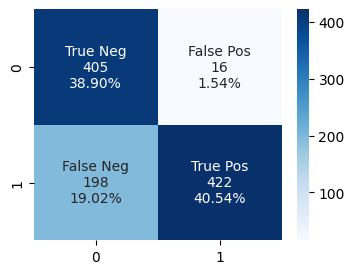

Decision Tree:


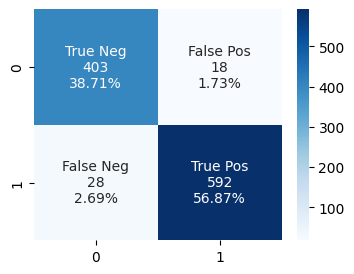

SVM:


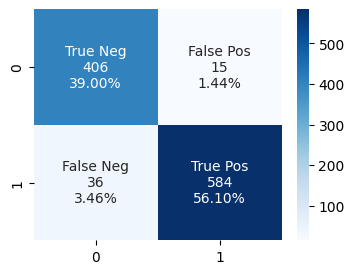

k-NN:


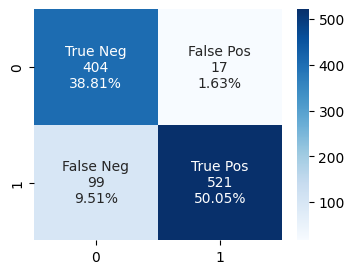

Random Forest:


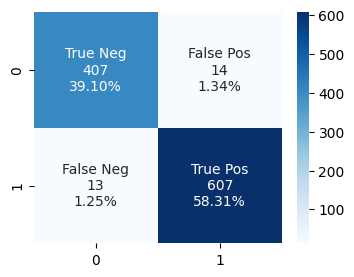

Gradient Tree Boosting:


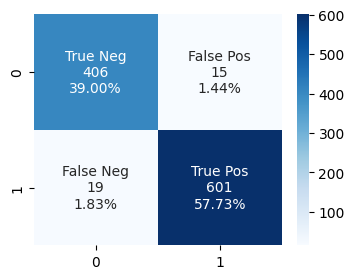

Multi-layer Perceptron:


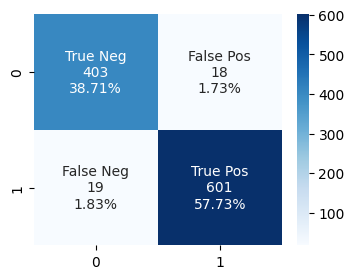

In [35]:
train_index, test_index = splits_5_fold[0]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
    
print('Naive Bayes:')
gnb = GaussianNB()
plot_cm(confusion_matrix(y_test, run_classifier(gnb, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

print('Decision Tree:')
dt = DecisionTreeClassifier(random_state=42, max_depth=7)
plot_cm(confusion_matrix(y_test, run_classifier(dt, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

print('SVM:')
svc = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(random_state=42, kernel='linear'))] )
plot_cm(confusion_matrix(y_test, run_classifier(svc, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

print('k-NN:')
knn = Pipeline( steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=3))] )
plot_cm(confusion_matrix(y_test, run_classifier(knn, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

print('Random Forest:')
rf = RandomForestClassifier(random_state=42, n_estimators=150)
plot_cm(confusion_matrix(y_test, run_classifier(rf, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

print('Gradient Tree Boosting:')
gtb = GradientBoostingClassifier(random_state=42, n_estimators=150)
plot_cm(confusion_matrix(y_test, run_classifier(gtb, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

print('Multi-layer Perceptron:')
mlp = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='relu', max_iter=10000))] )
plot_cm(confusion_matrix(y_test, run_classifier(mlp, X_train, X_test, y_train), labels=['CONFIRMED', 'FALSE POSITIVE']))

## Avaliação classificadores - Precision, Recall e F1-score

In [36]:
metrics = {
    'Naive Bayes': [],
    'Decision Tree': [],
    'SVM': [],
    'k-NN': [],
    'Random Forest': [],
    'Gradient Tree Boosting': [],
    'Multi-layer Perceptron': []
}
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    gnb = GaussianNB()
    metrics['Naive Bayes'].append(evaluate_classifier(y_test, run_classifier(gnb, X_train, X_test, y_train)))
    
    dt = DecisionTreeClassifier(random_state=42, max_depth=7)
    metrics['Decision Tree'].append(evaluate_classifier(y_test, run_classifier(dt, X_train, X_test, y_train)))
    
    svc = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(random_state=42, kernel='linear'))] )
    metrics['SVM'].append(evaluate_classifier(y_test, run_classifier(svc, X_train, X_test, y_train)))
    
    knn = Pipeline( steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=3))] )
    metrics['k-NN'].append(evaluate_classifier(y_test, run_classifier(knn, X_train, X_test, y_train)))
    
    rf = RandomForestClassifier(random_state=42, n_estimators=150)
    metrics['Random Forest'].append(evaluate_classifier(y_test, run_classifier(rf, X_train, X_test, y_train)))
    
    gtb = GradientBoostingClassifier(random_state=42, n_estimators=150)
    metrics['Gradient Tree Boosting'].append(evaluate_classifier(y_test, run_classifier(gtb, X_train, X_test, y_train)))
    
    mlp = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='relu', max_iter=10000))] )
    metrics['Multi-layer Perceptron'].append(evaluate_classifier(y_test, run_classifier(mlp, X_train, X_test, y_train)))

In [37]:
calculate_mean_metrics(metrics)

,Naive Bayes,Decision Tree,SVM,k-NN,Random Forest,Gradient Tree Boosting,Multi-layer Perceptron
Precision,0.673036,0.921974,0.921692,0.809268,0.963461,0.955672,0.944288
Recall/Sensitivity,0.974341,0.952002,0.961033,0.956754,0.963886,0.971965,0.952478
F1-Score,0.796112,0.936615,0.940909,0.876790,0.963619,0.963706,0.948200


## Análise Final

### Descrição das métricas
* Precision: É a proporção de previsões positivas corretas em relação ao total de previções positivas feitas pelo modelo.  
* Recall: É a proporção de previsões positivas corretas em relação ao total de verdadeiros positivos.  
* F1-Score: Pode ser visto como a média harmônica da precisão e recall. Muito útil em casos de classes desbalanciadas. 

### Modelos com as melhores performances
Random Forest e Gradient Tree Boosting.  
Ambos possuem os maiores valores de F1-Score. Porém, o Random Forest possui valores para Precision e Recall mais estabilizados. Isso indica que o Gradient Tree Boosting conseguiu acertar mais os verdadeiros positivos do que o Random Forest, em detrimento de trazer mais falsos positivos na classificação.  
O fato dos dois melhores modelos serem de ensemble evidencia a robustez desse tipo de algoritmo.

### Comentários gerais
Multi-layer Perceptron possui um bom equilíbrio entre Precision e Recall, assim como o Random Forest.  
Os outros algoritmos, principalmente o Naive Bayes, possuem um bom Recall em detrimento de um precisão pior.  
